### 1. 데이터세트를 로딩한다.주요 3가지 mode 있다: (1)train (2)test (3)train+test

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision

class advDataSet(Dataset):
    def __init__(self, mode='train'):
        self.mode = mode
        print('Loading dataset...')
        if self.mode == 'train':
            self.img_data = np.load('dataset/X_train.npy')
            self.label = np.load('dataset/y_train.npy')
        elif self.mode == 'test':
            self.img_data = np.load('dataset/X_test.npy')
            self.label = np.load('dataset/y_test.npy')
        elif self.mode == 'mixed':
            self.img_data = np.concatenate(
                (np.load('dataset/X_train.npy'), np.load('dataset/X_test.npy')),
                axis = 0
            )
            self.label = np.concatenate(
                np.load('dataset/X_train.npy'), np.load('dataset/X_test.npy')
            )
        else:
            raise RuntimeError
        assert len(self.img_data) == len(self.label)
        print("Initialized {} Dataset Done!".format(mode))

    
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self,idx):
        img = self.img_data[idx].transpose((2,0,1))
        label = self.label[idx]
        return torch.from_numpy(img).float(), label

### 2. 네트워크를 define한다. 다음으로 pre-train된 네트워크를 로딩한다.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, base_model):
        super(Model, self).__init__()
        self.base_model = base_model
        self.top_layer = nn.Sequential(
            nn.Linear(1000,10),
        )

    def forward(self,inp):
        out = self.base_model( inp )
        out = self.top_layer( out )
        return out, F.softmax(out, dim=1)

def get_model():
    base = torch.hub.load('pytorch/vision:v0.6.0','mobilenet_v2',pretrained=False)
    model = Model(base)
    model.load_state_dict(
        torch.load('cls_model_zoo/mobilenet_v2.ckpt')
    )
    return model

### 3. 마스터루틴: Deepfool 알고리즘의 운행

In [3]:
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
class DeepFool(object):
    def __init__(self,net,num_classes=10):
        self.num_classes = num_classes
        self.net = net
        self.softmax = torch.nn.Softmax(dim=1)
        self.cuda = torch.cuda.is_available()                   
        if self.cuda:
            self.net = self.net.cuda()
        self.net.eval()
    
    def deepfool(self, image, topk=5, overshoot=0.02, max_iter=100):
        '''
        |DeepFool Algorithm|
        image    : 오리지널 이미지
        topk     : topk번째 클래스에 교란을 계산함
        overshoot: 강제적으로 교란을 변화시키다(간과할 수 있다)
        max_iter : 최대 iteration
        '''
        self.net.eval()
        if len(image.size()) == 3:
            c, h, w = image.size()
            image = image.clone().view(1, c, h, w)
        image.requires_grad = True
        image = image.cuda() if self.cuda else image


        f_image = self.net.forward(image)[0]
        I = f_image.view(-1).sort(descending=True)[1]           
        I = I[0: topk]                                          
        label = I[0]                                            
        orig_p = self.softmax(f_image)[0][label].item()

        w = torch.zeros_like(image).cuda() if self.cuda else torch.zeros_like(image)
        r_tot = torch.zeros_like(image).cuda() if self.cuda else torch.zeros_like(image)

        loop_i = 0

        with torch.no_grad():
            x = image.clone()
        x.requires_grad = True
        fs = self.net(x)[0]
        fs_list = [fs[0, I[k]] for k in range(topk)]
        k_i = label

        while k_i == label and loop_i < max_iter:               
            pert = np.inf                                       
            fs[0, I[0]].backward(retain_graph=True)
            grad_orig = x.grad.data.clone()

            for k in range(1, topk):
                zero_gradients(x)

                fs[0, I[k]].backward(retain_graph=True)
                cur_grad = x.grad.data.clone()

                # set new w_k and new f_k
                w_k = cur_grad - grad_orig
                f_k = (fs[0, I[k]] - fs[0, I[0]]).data

                pert_k = abs(f_k)/torch.norm(w_k, p=2)

                # determine which w_k to use
                if pert_k < pert:
                    pert = pert_k
                    w = w_k

            # compute r_i and r_tot
            # Added 1e-4 for numerical stability
            r_i = (pert+1e-4) * w / torch.norm(w, p=2)  
            r_tot = r_tot + r_i

            pert_image = image + (1 + overshoot) * r_tot 

            with torch.no_grad():
                x = pert_image.clone()
            x.requires_grad = True
            fs = self.net(x)[0]
            probs = self.softmax(fs)
            k_i = torch.argmax(fs.data)

            loop_i += 1
            if loop_i % 100 == 0:
                print(loop_i, probs[0][k_i].item())

        r_tot = (1+overshoot) * r_tot 

        # r_tot:교란| loop_i:순환 횟수 | k_i:마지막의 예측 label | probs[0][label].item()：공격된 후에 오리지널 label에 대한 신뢰도 |
        #  probs[0][k_i].item()：오류 분류에 신뢰도 | pert_image : 교란을 추가하는 미미지
        return r_tot, loop_i, label, k_i, orig_p ,probs[0][label].item(), probs[0][k_i].item(), pert_image
    
    def deepWMfool(self, image, imgPlusWM, mask, topk=5, overshoot=0.02, max_iter=8000):
        '''
        |DeepFool with wm Algorithm|
        image    : 오리지널 이미지
        imgPlusWM: 오리지널 이미지+watermark
        mask     : 제한구역
        topk     : topk번째 클래스에 교란을 계산함
        overshoot: 강제적으로 교란을 변화시키다(간과할 수 있다)
        max_iter : 최대 iteration
        '''
        image = image.cuda() if self.cuda else image
        imgPlusWM = imgPlusWM.cuda() if self.cuda else imgPlusWM
        mask = mask.cuda() if self.cuda else mask
        self.net.eval()
        if len(image.size()) == 3:
            c, h, w = image.size()
            image = image.clone().view(1, c, h, w)
            imgPlusWM = imgPlusWM.clone().view(1, c, h, w)
        image.requires_grad = True
        imgPlusWM.requires_grad = True

        f_image = self.net.forward(imgPlusWM)[0]
        I = f_image.view(-1).sort(descending=True)[1]           # imgPlusWM의 신뢰도에 대해 정련함
        I = I[0: topk]                                      
        label = I[0]                                            # 예측된 label의 신뢰도는 가장 크다
        orig_p = self.softmax(f_image)[0][label].item()

        w = torch.zeros_like(image).cuda() if self.cuda else torch.zeros_like(image)
        r_tot = torch.zeros_like(image).cuda() if self.cuda else torch.zeros_like(image)

        loop_i = 0

        with torch.no_grad():
            x = imgPlusWM.clone()
        x.requires_grad = True
        fs = self.net(x)[0]
        fs_list = [fs[0, I[k]] for k in range(topk)]
        k_i = label

        while k_i == label and loop_i < max_iter:               # line160~line185 : DeepFool로서에 최소 교란을 계산
            pert = np.inf                                       # do iteration to k_i(예측 label) ≠ label(오리지널 label)
            fs[0, I[0]].backward(retain_graph=True)
            grad_orig = x.grad.data.clone()

            for k in range(1, topk):
                zero_gradients(x)

                fs[0, I[k]].backward(retain_graph=True)
                cur_grad = x.grad.data.clone()

                # set new w_k and new f_k
                w_k = cur_grad - grad_orig
                f_k = (fs[0, I[k]] - fs[0, I[0]]).data

                pert_k = abs(f_k)/torch.norm(w_k, p=2)

                # determine which w_k to use
                if pert_k < pert:
                    pert = pert_k
                    w = w_k

            # compute r_i and r_tot
            # Added 1e-4 for numerical stability
            r_i = (pert+1e-4) * w / torch.norm(w, p=2)  
            r_tot = r_tot + r_i

            pert_image = imgPlusWM + (1 + overshoot) * r_tot * mask  # 제한구역에서 교란을 추가함

            with torch.no_grad():
                x = pert_image.clone()
            x.requires_grad = True
            fs = self.net(x)[0]
            probs = self.softmax(fs)
            k_i = torch.argmax(fs.data)

            loop_i += 1
            if loop_i % 100 == 0:
                print(loop_i, probs[0][k_i].item())

        r_tot = (1+overshoot) * r_tot * mask

        # r_tot:교란| loop_i:순환 횟수 | k_i:마지막의 예측 label | probs[0][label].item()：오리지널 label에 공격한 후의 신뢰도 |
        #  probs[0][k_i].item()：오류 분류의 신뢰도 | pert_image : 교란 추가 후의 이미지
        return r_tot, loop_i, label, k_i, orig_p, probs[0][label].item(), probs[0][k_i].item(), pert_image


### 4. pre-train된 네트워크-mobilenet_v2의 정확율이 97%

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
net = get_model()
net = net.cuda()
dataset = advDataSet(mode='test')
TP = []
net.eval()
for i in range(len(dataset)):
    img,label = dataset[i]
    img = img.unsqueeze(0).cuda()
    
    outp = net(img)[1]
    if outp.max(1)[1].item()==label:
        TP.append(i)
print(len(TP))
TP = np.array(TP).astype(np.int)

Using cache found in /home/zql/.cache/torch/hub/pytorch_vision_v0.6.0


Loading dataset...
Initialized test Dataset Done!
485


### 5. 로고에 대한 전처리

In [5]:
from torchvision import transforms
from PIL import Image

def AddingWaterMask(img, wm_path, start_point=(0,0)):
    bkg_img = transforms.ToPILImage()(img)
    wm_img = transforms.Resize(50)(Image.open(wm_path))
    layer = Image.new('RGBA',bkg_img.size,(0,0,0,0))
    layer.paste(wm_img,start_point)
    r,g,b,a = layer.split()
    b = transforms.ToTensor()(b)
    b[b>0.9]=0
    b[b!=0]=1
    mask = b.clone()
    b = transforms.ToPILImage()(b)
    img2 = Image.composite(layer, bkg_img, b).convert('RGB')
    img2 = transforms.ToTensor()(img2)
    return img2, mask

100 0.9996098875999451
200 0.9932818412780762
300 0.9652928113937378
400 0.893979549407959
500 0.7675201892852783
600 0.6140241622924805
700 0.5445290207862854
800 0.5146018266677856
900 0.5042952299118042
1000 0.5005385875701904


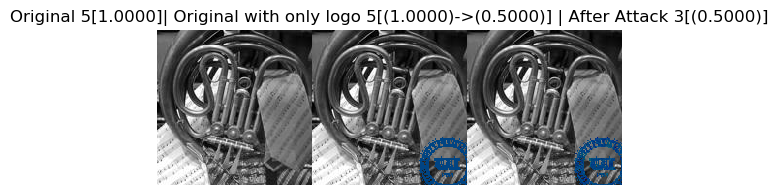

100 0.999001681804657
200 0.98189777135849
300 0.9444698095321655
400 0.8528010845184326
500 0.7423614859580994
600 0.6641678214073181
700 0.6121280789375305
800 0.578921377658844
900 0.5562263131141663
1000 0.5389057397842407
1100 0.5278913378715515
1200 0.5200902819633484
1300 0.5140155553817749
1400 0.5097469091415405
1500 0.5067121386528015
1600 0.5045146942138672
1700 0.5029287934303284
1800 0.5017877221107483
1900 0.5009292960166931
2000 0.5002949237823486


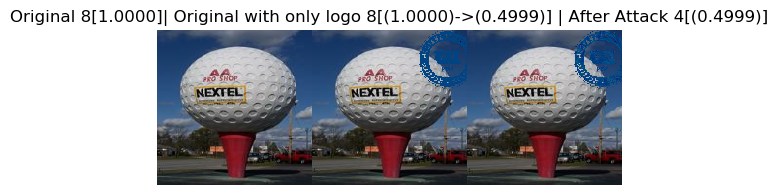

100 0.9993835687637329
200 0.9790828824043274
300 0.9014389514923096
400 0.7897446751594543
500 0.7019549608230591
600 0.6311770677566528
700 0.5854637026786804
800 0.5574100613594055
900 0.5374420881271362
1000 0.5232428312301636
1100 0.5139696002006531
1200 0.5081698298454285
1300 0.5045422315597534
1400 0.5022057890892029
1500 0.5007309317588806


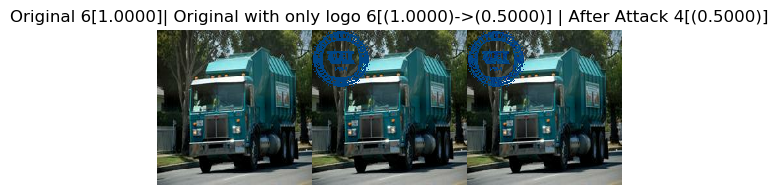

100 0.9999479055404663
200 0.9997450709342957
300 0.99906986951828
400 0.9974719882011414
500 0.9943276047706604
600 0.9883118271827698
700 0.9755759835243225
800 0.9596151113510132
900 0.9361640810966492
1000 0.9059095978736877
1100 0.8703328967094421
1200 0.8294693827629089
1300 0.7837716341018677
1400 0.7224220037460327
1500 0.6710377335548401
1600 0.6299260258674622
1700 0.5954117774963379
1800 0.5690093040466309
1900 0.5491269826889038
2000 0.534408688545227
2100 0.5237754583358765
2200 0.5164819359779358
2300 0.5111942291259766
2400 0.5072606205940247
2500 0.5044683814048767
2600 0.5024886727333069
2700 0.5010715126991272
2800 0.5000710487365723


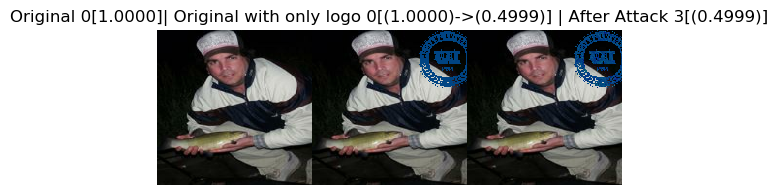

100 0.7447460889816284
200 0.512306272983551


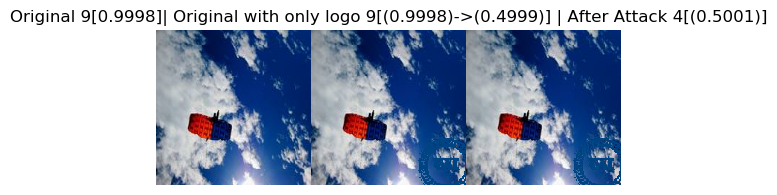

100 0.9957634210586548
200 0.9469605088233948
300 0.8322528600692749
400 0.6974866390228271
500 0.5987691283226013
600 0.5524062514305115
700 0.5273635983467102
800 0.5137342214584351
900 0.5063930749893188
1000 0.5023435950279236
1100 0.5001153945922852


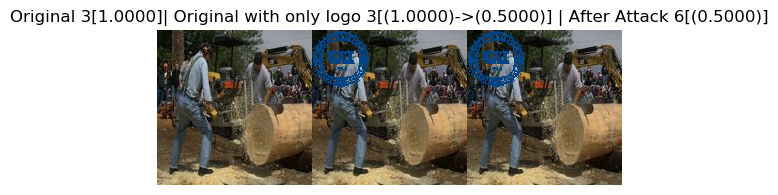

100 0.4510381519794464
200 0.44158580899238586


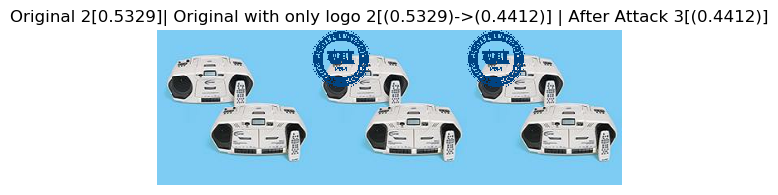

100 0.9387701749801636
200 0.7470154166221619
300 0.6167780160903931
400 0.5492199659347534
500 0.5186183452606201
600 0.5059157609939575
700 0.5005492568016052


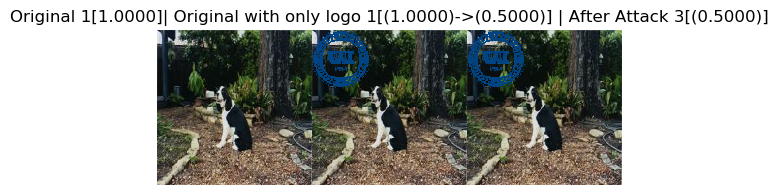

100 0.9917328357696533
200 0.9790736436843872
300 0.9633100628852844
400 0.9403554201126099
500 0.917540431022644
600 0.8906340599060059
700 0.8601927161216736
800 0.830455482006073
900 0.7978176474571228
1000 0.7658904194831848
1100 0.7378243207931519
1200 0.7089565992355347
1300 0.6829045414924622
1400 0.6593273282051086
1500 0.6395387053489685
1600 0.6217127442359924
1700 0.6060558557510376
1800 0.5926825404167175
1900 0.5805179476737976
2000 0.5698365569114685
2100 0.5606186985969543
2200 0.5522521734237671
2300 0.5447875261306763
2400 0.5383745431900024
2500 0.5327675342559814
2600 0.5280508995056152
2700 0.5240464210510254
2800 0.5205246806144714
2900 0.517541229724884
3000 0.514959990978241
3100 0.5127418637275696
3200 0.5108198523521423
3300 0.509112536907196
3400 0.5076341032981873
3500 0.5063657164573669
3600 0.5052455067634583
3700 0.504258394241333
3800 0.5034082531929016
3900 0.5026784539222717
4000 0.5020567178726196
4100 0.5015212297439575
4200 0.5010608434677124
4300 0.

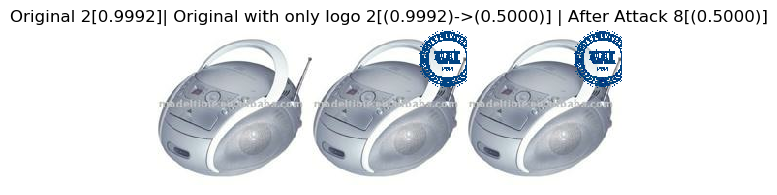

100 1.0
200 1.0
300 0.9999998807907104
400 0.9999994039535522
500 0.999997615814209
600 0.9999933242797852
700 0.9999849796295166
800 0.9999713897705078
900 0.9999470710754395
1000 0.9999127388000488
1100 0.9998667240142822
1200 0.9997965693473816
1300 0.9996988773345947
1400 0.9995593428611755
1500 0.9993614554405212
1600 0.9990952014923096
1700 0.9987012147903442
1800 0.998195469379425
1900 0.9974778294563293
2000 0.9963601231575012
2100 0.9947082996368408
2200 0.9921042919158936
2300 0.98897385597229
2400 0.9850680232048035
2500 0.9800215363502502
2600 0.9740622043609619
2700 0.967545747756958
2800 0.960139811038971
2900 0.9521409273147583
3000 0.9431521892547607
3100 0.9333128929138184
3200 0.9209066033363342
3300 0.9079126119613647
3400 0.8955069780349731
3500 0.8820112347602844
3600 0.8688637018203735
3700 0.8556118011474609
3800 0.8425515294075012
3900 0.8298991918563843
4000 0.8175394535064697
4100 0.8052805066108704
4200 0.7936488389968872
4300 0.7821703553199768
4400 0.771190

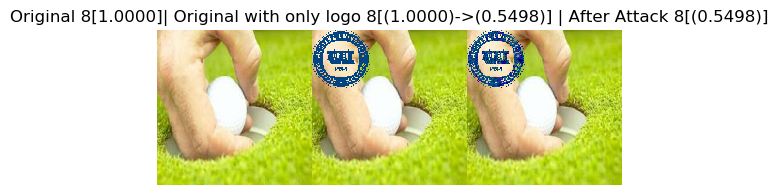

100 0.7495008111000061
200 0.5788009762763977
300 0.5224379897117615
400 0.5057509541511536
500 0.5004039406776428


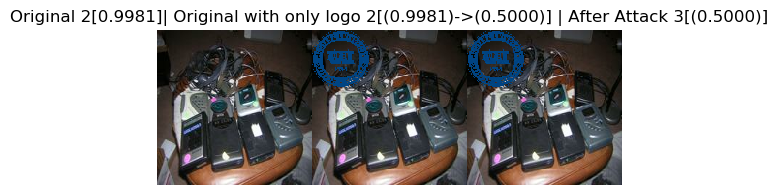

100 0.9999996423721313
200 0.9999043941497803
300 0.9977050423622131
400 0.9860763549804688
500 0.957252025604248
600 0.908789336681366
700 0.8544858694076538
800 0.7991896867752075
900 0.7470057606697083
1000 0.6996935606002808
1100 0.6596185564994812
1200 0.6250246167182922
1300 0.5972667336463928
1400 0.575091540813446
1500 0.558336079120636
1600 0.5449177026748657
1700 0.5344469547271729
1800 0.5260969996452332
1900 0.5196658968925476
2000 0.5148723125457764
2100 0.5112177729606628
2200 0.5083940625190735
2300 0.5061951875686646
2400 0.5044892430305481
2500 0.5031599402427673
2600 0.5021157264709473
2700 0.5013039112091064
2800 0.5006628036499023
2900 0.5001585483551025


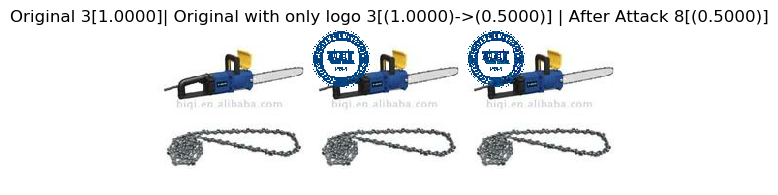

100 0.997369647026062
200 0.9758578538894653
300 0.9260643124580383
400 0.8509993553161621
500 0.7685328125953674
600 0.686512291431427
700 0.6292954087257385
800 0.5886660814285278
900 0.5595912933349609
1000 0.5394728183746338
1100 0.5262738466262817
1200 0.5172592401504517
1300 0.5111156105995178
1400 0.5069122910499573
1500 0.5040498375892639
1600 0.5020871162414551
1700 0.5007405281066895
1800 0.4998282194137573


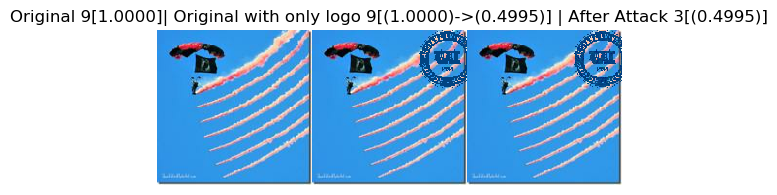

100 0.996683657169342
200 0.9020504951477051
300 0.7601192593574524
400 0.6545588970184326
500 0.5894583463668823
600 0.5524991750717163
700 0.5308056473731995
800 0.5177751779556274
900 0.5100885033607483
1000 0.5055258274078369
1100 0.5027050375938416
1200 0.5009689331054688


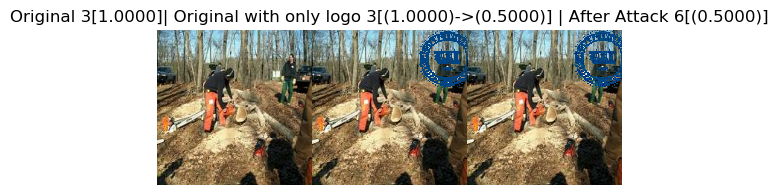

100 0.9997488856315613
200 0.9879651069641113
300 0.939245879650116
400 0.8446783423423767
500 0.7258767485618591
600 0.6502333283424377
700 0.5980578064918518
800 0.5618423819541931
900 0.5378235578536987
1000 0.522730827331543
1100 0.5133422017097473
1200 0.5076196789741516
1300 0.5041834712028503
1400 0.5020664930343628
1500 0.5007480978965759


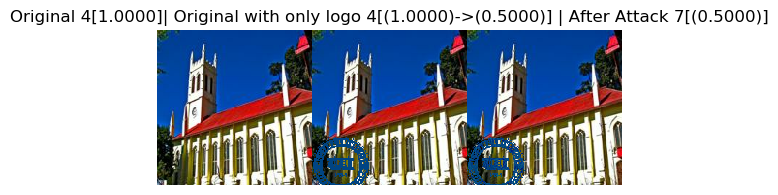

100 0.978469967842102
200 0.7700855135917664
300 0.6130739450454712
400 0.5516773462295532
500 0.5236129760742188
600 0.5105717182159424
700 0.5042880177497864
800 0.5012285709381104


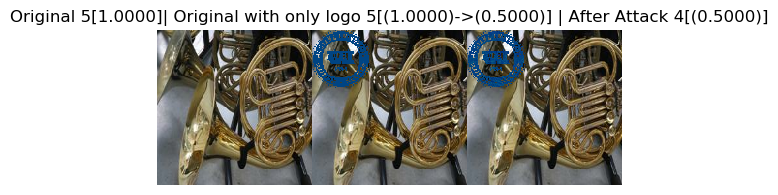

100 0.9999995231628418
200 0.9999938011169434
300 0.9999288320541382
400 0.9995641112327576
500 0.9981880784034729
600 0.9952274560928345
700 0.9897676110267639
800 0.9808773398399353
900 0.9698633551597595
1000 0.9552825093269348
1100 0.9366638660430908
1200 0.9165663719177246
1300 0.8963906168937683
1400 0.8733735680580139
1500 0.8463804721832275
1600 0.8185656070709229
1700 0.7892447710037231
1800 0.7637100219726562
1900 0.7401182651519775
2000 0.7170244455337524
2100 0.6957008242607117
2200 0.6760215163230896
2300 0.6575273275375366
2400 0.6401029825210571
2500 0.6239843964576721
2600 0.6090420484542847
2700 0.5939077734947205
2800 0.5812332034111023
2900 0.5705462098121643
3000 0.5613351464271545
3100 0.5531643033027649
3200 0.5462948679924011
3300 0.5403255820274353
3400 0.5352539420127869
3500 0.5308104157447815
3600 0.526896059513092
3700 0.5234819650650024
3800 0.5204400420188904
3900 0.5178264379501343
4000 0.5155504941940308
4100 0.5135688185691833
4200 0.5118406414985657
43

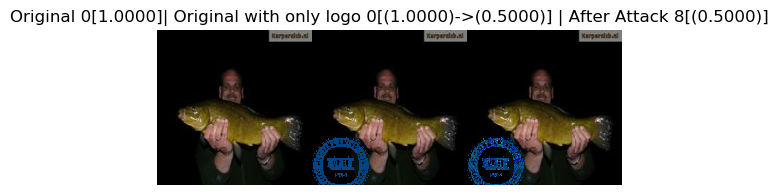

100 0.9998725652694702
200 0.9997442364692688
300 0.999570906162262
400 0.9992469549179077
500 0.9988296627998352
600 0.9983648657798767
700 0.9979164004325867
800 0.9974821209907532
900 0.9969927072525024
1000 0.9962561130523682
1100 0.9951445460319519
1200 0.9937283992767334
1300 0.991943359375
1400 0.9897913336753845
1500 0.9871085286140442
1600 0.9836375117301941
1700 0.9775913953781128
1800 0.9649441838264465
1900 0.9409206509590149
2000 0.9077614545822144
2100 0.8686143755912781
2200 0.7900153398513794
2300 0.6975886225700378
2400 0.6275454163551331
2500 0.5842596888542175
2600 0.5527989268302917
2700 0.5289028882980347
2800 0.514991044998169
2900 0.5076966881752014
3000 0.503780722618103
3100 0.5015770792961121
3200 0.5003606677055359


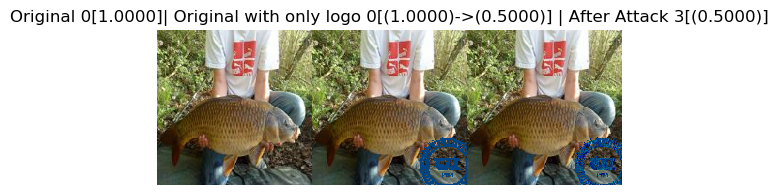

100 0.5058298110961914


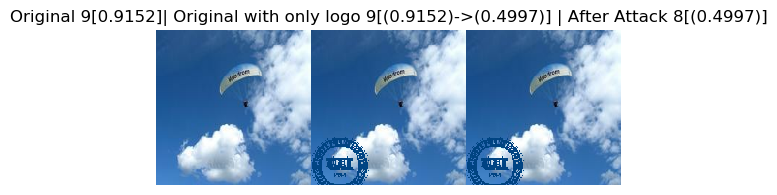

100 0.7638548612594604
200 0.6092100739479065
300 0.5489574074745178
400 0.5218721628189087
500 0.5096560120582581
600 0.5037859082221985
700 0.5008711814880371


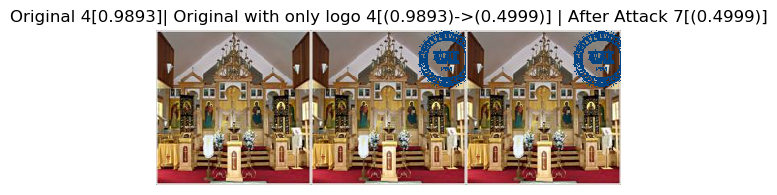

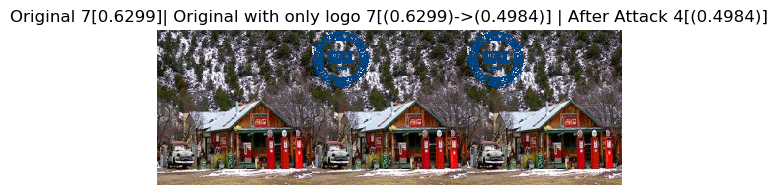

100 0.9844560623168945
200 0.8690367937088013
300 0.7149865627288818
400 0.6164288520812988
500 0.5612987279891968
600 0.5312284827232361
700 0.5151596069335938
800 0.5064720511436462
900 0.5020458698272705
1000 0.4999087154865265


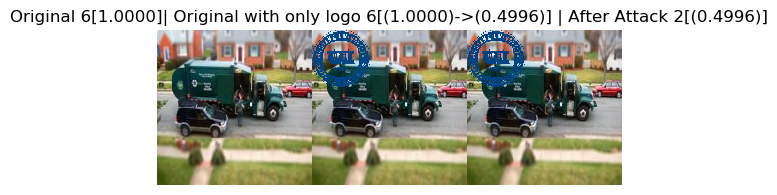

100 0.975433349609375
200 0.8993093371391296
300 0.8160172700881958
400 0.7416531443595886
500 0.6770260334014893
600 0.6310835480690002
700 0.597806990146637
800 0.5723720192909241
900 0.5529096126556396
1000 0.5382919907569885
1100 0.5273009538650513
1200 0.519502580165863
1300 0.5137574076652527
1400 0.5096775889396667
1500 0.5066631436347961
1600 0.5044898986816406
1700 0.5028831958770752
1800 0.5016912221908569
1900 0.5008080005645752
2000 0.5001554489135742


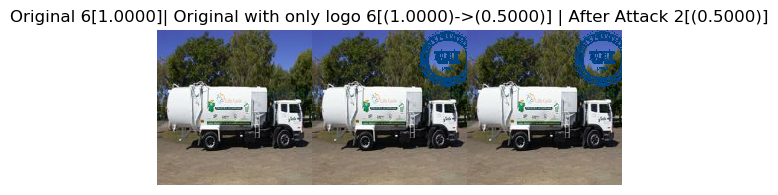

100 0.999975323677063
200 0.9979416728019714
300 0.9662785530090332
400 0.9038040041923523
500 0.8333259224891663
600 0.7682474851608276
700 0.7101592421531677
800 0.6586704254150391
900 0.6166700124740601
1000 0.585401177406311
1100 0.5621722936630249
1200 0.544849693775177
1300 0.5304581522941589
1400 0.5207058787345886
1500 0.5137349963188171
1600 0.5089231729507446
1700 0.5056246519088745
1800 0.50335294008255
1900 0.5017152428627014
2000 0.5005548596382141


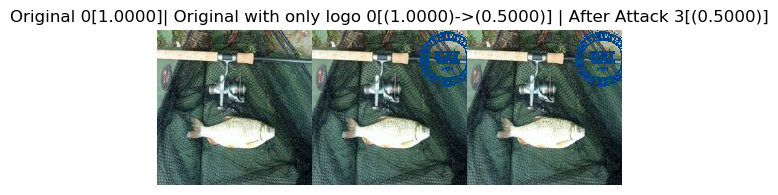

100 1.0
200 0.9999997615814209
300 0.9999991655349731
400 0.9999984502792358
500 0.9999972581863403
600 0.9999959468841553
700 0.9999936819076538
800 0.9999914169311523
900 0.9999886751174927
1000 0.9999854564666748
1100 0.9999821186065674
1200 0.9999788999557495
1300 0.999975323677063
1400 0.9999704360961914
1500 0.9999655485153198
1600 0.9999608993530273
1700 0.9999548196792603
1800 0.999947190284729
1900 0.99993896484375
2000 0.9999277591705322
2100 0.9999152421951294
2200 0.999901294708252
2300 0.9998832941055298
2400 0.9998615980148315
2500 0.9998397827148438
2600 0.9998161196708679
2700 0.9997894167900085
2800 0.9997510313987732
2900 0.9997015595436096
3000 0.9996503591537476
3100 0.9995948672294617
3200 0.9995321035385132
3300 0.9994727969169617
3400 0.9994105100631714
3500 0.9993442893028259
3600 0.9992789626121521
3700 0.9992063641548157
3800 0.9991330504417419
3900 0.9990517497062683
4000 0.9989715814590454
4100 0.9988787770271301
4200 0.9987843632698059
4300 0.99868708848953

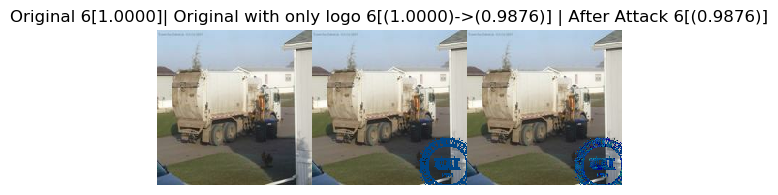

100 0.5221714973449707


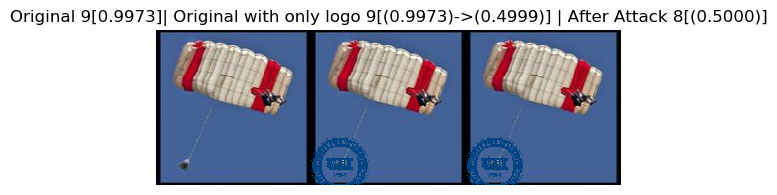

100 0.9998441934585571
200 0.99973064661026
300 0.9996317625045776
400 0.9995216131210327
500 0.9994181394577026
600 0.9992843270301819
700 0.9991443157196045
800 0.9989830851554871
900 0.9987747073173523
1000 0.99859219789505
1100 0.9984191656112671
1200 0.9982271790504456
1300 0.9980210065841675
1400 0.9978252649307251
1500 0.9975864887237549
1600 0.9973360896110535
1700 0.9969293475151062
1800 0.9964514970779419
1900 0.9958756566047668
2000 0.9951942563056946
2100 0.9944355487823486
2200 0.9937514662742615
2300 0.9930626749992371
2400 0.9921173453330994
2500 0.9910203814506531
2600 0.9899550676345825
2700 0.988953709602356
2800 0.9879051446914673
2900 0.9868944883346558
3000 0.9859421849250793
3100 0.9845544695854187
3200 0.9833096861839294
3300 0.9822061061859131
3400 0.9811687469482422
3500 0.9801503419876099
3600 0.978939950466156
3700 0.977739155292511
3800 0.9765324592590332
3900 0.9753274321556091
4000 0.9740789532661438
4100 0.9727426767349243
4200 0.9713699221611023
4300 0.9

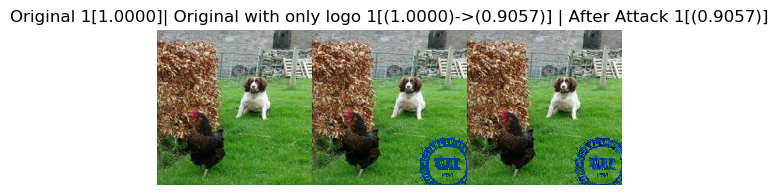

100 0.6815856695175171
200 0.5097816586494446


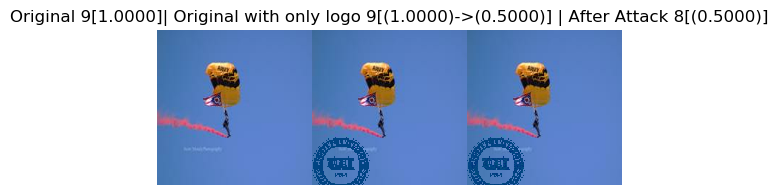

100 0.9999125003814697
200 0.9958701729774475
300 0.9556267261505127
400 0.878082275390625
500 0.7921987771987915
600 0.7131848931312561
700 0.655127227306366
800 0.6143050193786621
900 0.5826775431632996
1000 0.5586043000221252
1100 0.54191654920578
1200 0.5297963619232178
1300 0.5212618112564087
1400 0.5150159001350403
1500 0.5104932188987732
1600 0.5071013569831848
1700 0.5045520663261414
1800 0.5026918053627014
1900 0.5013483166694641
2000 0.5003796219825745


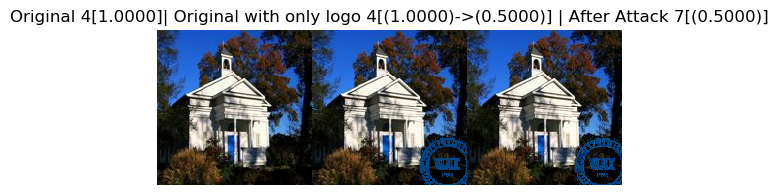

100 0.8613621592521667
200 0.6426708698272705
300 0.5562605857849121
400 0.5194324851036072
500 0.5059823989868164
600 0.501032829284668


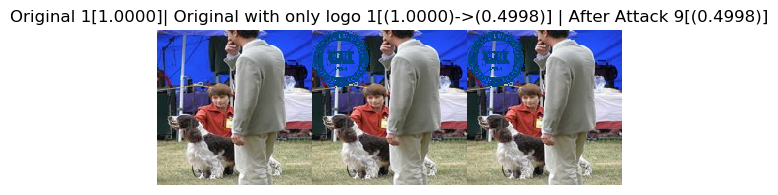

In [8]:
choice = np.random.choice(TP, size=30, replace=False)
sp = [(0,0),(110,0),(0,110),(110,110)] # logo's location. image size: 160 - logo size: 50
DF = DeepFool(net,10)
for i in choice:
    img = dataset[i][0]
    gt = dataset[i][1]
    wm_img,mask = AddingWaterMask(img,'logo/hyu.png',sp[np.random.randint(4)]) # Choose the logo you want to use
    with torch.no_grad():
        p_of_ori = DF.net(wm_img.unsqueeze(0).cuda())[1][0][gt].item()
    _,loop,label,k_i,orig_p,af_p,f_p,pert_img = DF.deepWMfool(img,wm_img,mask)

    img = img.data.cpu().numpy().transpose((1,2,0))
    wm_img = wm_img.data.cpu().numpy().transpose((1,2,0))
    pert_img = pert_img.clamp(0,1).squeeze().data.cpu().numpy().transpose((1,2,0))
    
    
    
    show_img = np.concatenate((img,wm_img,pert_img),axis=1)
    title = 'Original {}[{:.4f}]| Original with only logo {}[({:.4f})->({:.4f})] | After Attack {}[({:.4f})]'.format(gt,p_of_ori,label,orig_p,af_p,k_i,f_p)
    plt.imshow(show_img)
    plt.title(title)
    plt.axis('off')
    plt.rcParams['figure.dpi'] = 100
    plt.savefig('DFlogo_result/{}.png'.format(i), dpi=100, bbox_inches = 'tight')
    plt.show()